<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

# Theory schema

In [2]:
from IPython.display import Image

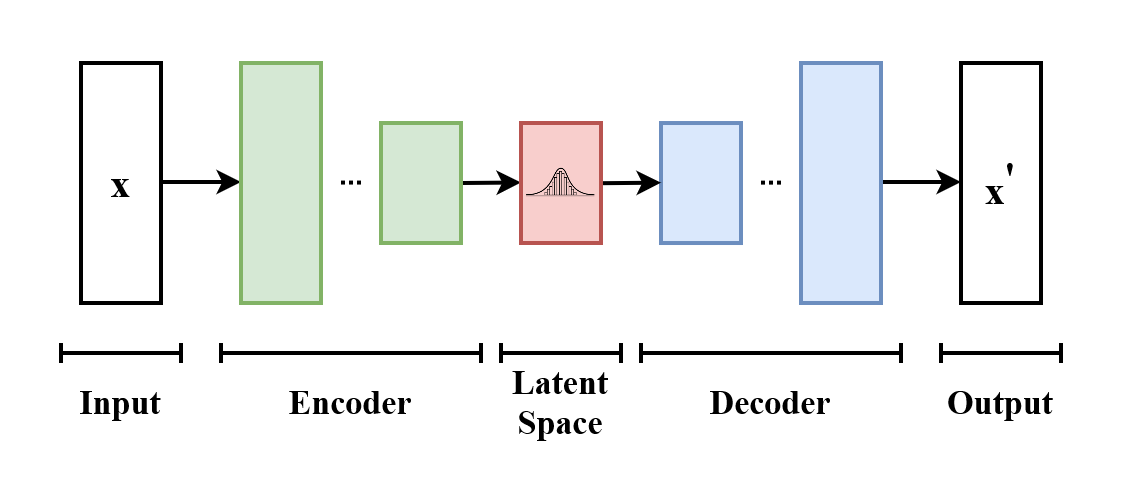

In [3]:
Image(filename="Images/VAE_Basic.png")

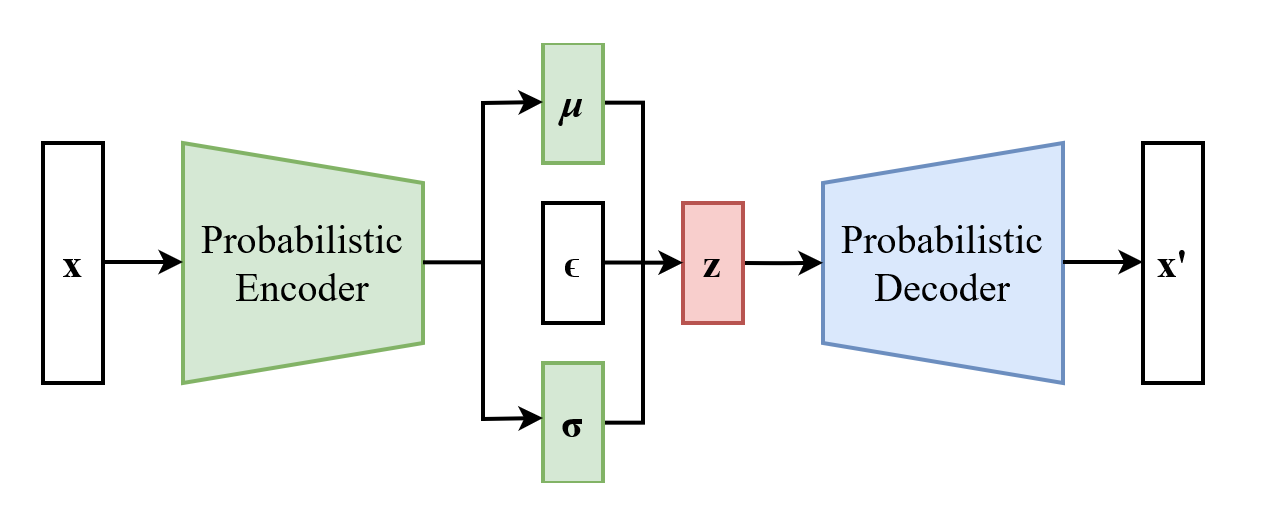

In [4]:
Image(filename="Images/Reparameterized_Variational_Autoencoder.png")

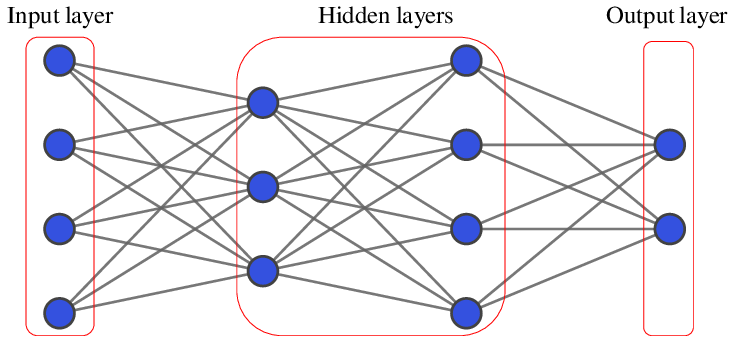

In [5]:
Image(filename="Images/FFNN.png")

# 0. Libraries

In [6]:
%load_ext autoreload
%autoreload 2

In [34]:
import os
import random
import pickle
from typing import List
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from VariationalModel import *
from Functions import *
from Classes import *

## Dataset

In [9]:
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

Selected device: mps


In [10]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

print(f"Length of the train dataset: {len(trainDataset)}")
print(f"Length of the test dataset: {len(testDataset)}")

Length of the train dataset: 60000
Length of the test dataset: 10000


In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [11]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [12]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])
TEST BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])


# 2. VAE model

## Set up model - RELU -

In [ ]:
model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[400, 300, 200, 100, 50],
                               activation_enc=nn.ReLU,
                               activation_dec=nn.ReLU,
                               Variational = True
                              )

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

## Training Model

In [ ]:
# global usefull elements

epochs = 20

method_mi="kde"
sigmaKDE = 1
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [ ]:
def Training(model, optimizer, loss_fn, num_epochs, mi_estimator, sampleMI, showImage=False, doTest=False):
    
    # Setting hooks
    RecorderActivat.InitialRegister(model)
    model.to(device)

    LatentMI = []
    LayerActivation = {f'Layer_{j}': [] for j in range(len(model.Encoder))}

    #------------Visualization of the activation of the weights
    #Takes a minibatch of images
    data_iter = iter(testDataloader)
    inputs, labels = next(data_iter)
    x = inputs.view(inputs.size(0), -1).to(device)
    
    h = x
    for j, layer in enumerate(model.Encoder):
        h = layer(h)
        # Save immediately
        LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
   
   
    for epoch in tqdm(range(num_epochs)):
        model.train()
        losses = []
        clear_output(wait=True)
        
        for images, _ in (trainDataloader):#, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = images.view(images.size(0), -1)
            
            outputs, z, mean, logVar = model(images)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        avg_train_loss = np.mean(losses)
        model.train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        avg_val_loss = None
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    targets = images.view(images.size(0), -1)
                    outputs, z = model(images)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.item())
            
            avg_val_loss = np.mean(val_losses)
            model.val_loss_history.append(avg_val_loss)

        # --- MI Calculation ---
        res = VAE_info(
            model, 
            trainDataset, 
            device, 
            epoch=epoch, 
            num_samples=sampleMI, 
            mi_estimator=mi_estimator, 
            RecorderActivat=RecorderActivat)
        mi_history.append(res)

        test = LatentVAE_Info(model, trainDataset, device, epoch=epoch, num_samples=sampleMI, mi_estimator=mi_estimator, RecorderActivat=RecorderActivat)
        LatentMI.append(test)


        #------------Visualization of the activation of the weights
        #Takes a minibatch of images
        data_iter = iter(testDataloader)
        inputs, labels = next(data_iter)
        x = inputs.view(inputs.size(0), -1).to(device)
        
        h = x
        for j, layer in enumerate(model.Encoder):
            h = layer(h)
            # Append to the existing list for this layer
            LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
        
        # --- Print & Show ---
        val_str = f" — val: {avg_val_loss:.4f}" if avg_val_loss else ""
        print(f"Epoch {epoch+1} — train: {avg_train_loss:.4f}{val_str}")

        if showImage and (epoch % 5 == 0 or epoch == num_epochs - 1):
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img.cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().view(28, 28), cmap='gray')
            axs[1].set_title("Recon")
            plt.show()
            plt.close()

    return np.mean(losses), LatentMI, LayerActivation

In [ ]:
final_loss = Training(
    model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=500,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

# 3. Diagnostic

## Inspect elements

### Mutual Information history

In [ ]:
#mi_history.show("encoder")

In [ ]:
#mi_history.show("decoder")

In [ ]:
#mi_history.show("global")

### Activations

In [ ]:
# last epoch (check below with all history of activations)
#RecorderActivat.activations

In [ ]:
# to check that every epochs activations was saved
assert len(RecorderActivat.history) == epochs #+ 1 (with +1 gives an error)

In [ ]:
#RecorderActivat.history

## Distances/distributions of activations

In [ ]:
plot_kde_geometry(recorder=RecorderActivat, mi_estimator=mi_estimator, part="decoder", layer=3, epoch=3)

In [ ]:
plot_kde_geometry(recorder=RecorderActivat, mi_estimator=mi_estimator, part="latent",epoch=3)

In [ ]:
# plot_kde_geometry(
#     recorder=RecorderActivat,
#     mi_estimator=mi_estimator,
#     part="encoder",
#     layer=2,
#     epoch=5
# )

In [ ]:
# plot_kde_geometry(
#     recorder=RecorderActivat,
#     mi_estimator=mi_estimator,
#     part="encoder",
#     layer=2,
#     neuron=50,
#     epoch=5
# )

In [ ]:
# # sui layer encoder

# for l in range(1, 5):
#     plot_kde_geometry(
#         recorder=RecorderActivat,
#         mi_estimator=mi_estimator,
#         part="encoder",
#         layer=l,
#         epoch=5
#     )

In [ ]:
# # sui neuroni

# for neuron in range(1, 11):
#     plot_kde_geometry(
#         recorder=RecorderActivat,
#         mi_estimator=mi_estimator,
#         part="encoder",
#         layer=2,
#         neuron=neuron,
#         epoch=5
#     )

# 4. Results

## Mutual Information

In [ ]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=-1, Step=1)

In [ ]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=6, end_epoch=15, Step=1)

## VAE outputs

In [ ]:
ShowSomeImages(model, testDataset, device)

## VAE loss

In [ ]:
model.plot_loss()

--------

# Studying $\tanh$ activation

In [ ]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=128, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=128, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

In [ ]:
tanh_model = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[200, 150, 100, 50],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

tanh_model.to(device)

In [ ]:
# same implementation as above
optimizer = torch.optim.Adam(tanh_model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

# global usefull elements
epochs = 6

method_mi="kde"
sigmaKDE = 2
n_neigKRASKOV = 3

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE, n_neig=n_neigKRASKOV )

In [ ]:
#---------- TRAINING ------------
final_loss = Training(
    tanh_model,
    optimizer,
    loss_fn,
    num_epochs=epochs, 
    sampleMI=1000,
    mi_estimator=mi_estimator,
    showImage=False,
    doTest=False
)

In [ ]:
#--------- DIAGNOSTIC ------------
#mi_history.show("encoder")

In [ ]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=1)

In [ ]:
ShowSomeImages(tanh_model, testDataset, device)

## Checking the SAXE paper about linearity and non-linearity

In [ ]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

In [ ]:
modelReLU = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[300, 100, 50],
                               activation_enc=nn.ReLU,
                               activation_dec=nn.ReLU,
                               Variational = True
                              )

modelReLU.to(device)

optimizer = torch.optim.Adam(modelReLU.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [ ]:
epochs = 20

method_mi="kde"
sigmaKDE = 1

RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi, sigma=sigmaKDE)

finalLoss_ReLU, LatentMI_ReLU,LayerActivation  = Training(modelReLU, optimizer, loss_fn, num_epochs=epochs, sampleMI=500, mi_estimator=mi_estimator,)

In [ ]:
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=10, end_epoch=epochs, Step=1)

In [ ]:
AnimateActivations(LayerActivation, layer = 1)

In [ ]:
modelTanh = VariationalAutoEncoder(latentDim = 10,
                               hiddenDim=[30, 20],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

modelTanh.to(device)

optimizer = torch.optim.Adam(modelTanh.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()

In [ ]:
epochs = 25
method_mi="kde"


RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi)

finalLoss_Tanh, LatentMI_Tanh, EpochsActiv = Training(modelTanh, optimizer, loss_fn, num_epochs=epochs, sampleMI=500, mi_estimator=mi_estimator,)

In [ ]:
plt.plot(LatentMI_Tanh)
plt.grid(True, alpha = 0.5)
plt.xlabel("Epochs")
plt.ylabel("Mutual information I(X:Z)")

In [ ]:
AnimateActivations(EpochsActiv, layer = 0)

In [ ]:
AnimateActivations(EpochsActiv, layer = 1)

In [ ]:
modelTanh2 = VariationalAutoEncoder(latentDim = 20,
                               hiddenDim=[300, 200, 100],
                               activation_enc=nn.Tanh,
                               activation_dec=nn.Tanh,
                               Variational = True
                              )

modelTanh2.to(device)

optimizer = torch.optim.Adam(modelTanh2.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

epochs = 80
method_mi="kde"


RecorderActivat = ActivationRecorder()
mi_history = MI_History()
mi_estimator = MI_Estimator(method=method_mi)

finalLoss_Tanh, LatentMI_Tanh2, EpochsActiv2 = Training(modelTanh2, optimizer, loss_fn, num_epochs=epochs, sampleMI=1000, mi_estimator=mi_estimator,)

In [ ]:
plt.plot(LatentMI_Tanh2)
plt.grid(True, alpha = 0.5)
plt.xlabel("Epochs")
plt.ylabel("Mutual information I(X:Z)")

In [ ]:
AnimateActivations(EpochsActiv2, layer = 0)

In [ ]:
AnimateActivations(EpochsActiv2, layer = 1)

In [ ]:
AnimateActivations(EpochsActiv2, layer = 2)

In [ ]:
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=epochs, Step=3)

## Changing architecture and latent space dimension

In [56]:
# Loading dataset
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

batch_size = 128
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

In [57]:
def GeneralTraining(model, optimizer, loss_fn, num_epochs, activation_rec: ActivationRecorder, mi_history: MI_History, mi_estimator, sampleMI, showImage=False, doTest=False):
    
    # Setting hooks
    activation_rec.InitialRegister(model)
    model.to(device)

    LatentMI = []
    LayerActivation = {f'Layer_{j}': [] for j in range(len(model.Encoder))}

    #------------Visualization of the activation of the weights
    #Takes a minibatch of images
    data_iter = iter(testDataloader)
    inputs, labels = next(data_iter)
    x = inputs.view(inputs.size(0), -1).to(device)
    
    h = x
    for j, layer in enumerate(model.Encoder):
        h = layer(h)
        # Save immediately
        LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
   
   
    for epoch in tqdm(range(num_epochs)):
        model.train()
        losses = []
        clear_output(wait=True)
        
        for images, _ in (trainDataloader):#, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            targets = images.view(images.size(0), -1)
            
            outputs, z, mean, logVar = model(images)
            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        avg_train_loss = np.mean(losses)
        model.train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        avg_val_loss = None
        if doTest:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)
                    targets = images.view(images.size(0), -1)
                    outputs, z = model(images)
                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.item())
            
            avg_val_loss = np.mean(val_losses)
            model.val_loss_history.append(avg_val_loss)

        # --- MI Calculation ---
        res = VAE_info(
            model, 
            trainDataset, 
            device, 
            epoch=epoch, 
            num_samples=sampleMI, 
            mi_estimator=mi_estimator, 
            RecorderActivat=activation_rec)
        mi_history.append(res)

        test = LatentVAE_Info(model, trainDataset, device, epoch=epoch, num_samples=sampleMI, mi_estimator=mi_estimator, RecorderActivat=activation_rec)
        LatentMI.append(test)


        #------------Visualization of the activation of the weights
        #Takes a minibatch of images
        data_iter = iter(testDataloader)
        inputs, labels = next(data_iter)
        x = inputs.view(inputs.size(0), -1).to(device)
        
        h = x
        for j, layer in enumerate(model.Encoder):
            h = layer(h)
            # Append to the existing list for this layer
            LayerActivation[f'Layer_{j}'].append(h.detach().cpu().numpy().flatten())
        
        # --- Print & Show ---
        val_str = f" — val: {avg_val_loss:.4f}" if avg_val_loss else ""
        print(f"Epoch {epoch+1} — train: {avg_train_loss:.4f}{val_str}")

        if showImage and (epoch % 5 == 0 or epoch == num_epochs - 1):
            model.eval()
            img = testDataset[0][0].unsqueeze(0).to(device)
            with torch.no_grad():
                recon = model(img)[0]
            
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img.cpu().squeeze(), cmap='gray')
            axs[0].set_title("Original")
            axs[1].imshow(recon.cpu().squeeze().view(28, 28), cmap='gray')
            axs[1].set_title("Recon")
            plt.show()
            plt.close()

    return np.mean(losses), LatentMI, LayerActivation

In [75]:
def TrainDifferentArchitectures(hidden_dimensions, latent_dimensions, epochs, lr=5e-4, file_name=""):
    '''
        Iterates the VAE training over a grid and saves the MI_history of each train in a dictionary.


        The grid is made by all the combinations (cartesian prod.) of hidden_dimensions (VAE architectures) and 
        latent_dimension (dimensions of the latent space). 
        If file_name is provided, it creates a file containing a list of MI_History objects.
    '''

    grid = product(hidden_dimensions, latent_dimensions)
    mi_histories = {}

    for h_dim, Z in grid:

        print(f"----- Training VAE with hidden space dim. {Z} and hidden layers dim. {h_dim} ------\n\n")

        model = VariationalAutoEncoder(
            latentDim=Z,
            hiddenDim=h_dim,
            activation_enc=nn.Tanh,
            activation_dec=nn.Tanh,
            Variational=True
        )

        model.to(device)

        # Training parameters
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.MSELoss()
        epochs = epochs
        method_mi="kde"
        sigmaKDE = 1

        # Instances for recording MI evolution
        activation_rec = ActivationRecorder()
        mi_history = MI_History()
        mi_estimator = MI_Estimator( method=method_mi, sigma=sigmaKDE)

        # Train and plot MI
        _, _, _ = GeneralTraining(
            model, 
            optimizer, 
            loss_fn, 
            num_epochs=epochs, 
            sampleMI=1000, 
            mi_history=mi_history,
            activation_rec=activation_rec,
            mi_estimator=mi_estimator
            )
        
        mi_history.show()
        mi_histories[str((h_dim, Z))] = mi_history

    if file_name != "":
        with open(file_name, "wb") as f:
            pickle.dump(mi_histories, f)
    else:
        return mi_histories

1) Fix VAE architecture and change latent space dimension

In [ ]:
hidden_dimensions = [[200, 100, 50]]
latent_dimensions = [10, 25, 50]
mi_histories = TrainDifferentArchitectures(hidden_dimensions, latent_dimensions, epochs=2, lr = 5e-4)

100%|██████████| 2/2 [00:09<00:00,  4.99s/it]

Epoch 2 — train: 0.0674
==================== MI HISTORY (all) ====================
EPOCH 1
  [Global] I(Input, Z): 6.896 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=1.261 | I(L, Z)=1.264
    Layer 2: I(Input, L)=0.040 | I(L, Z)=0.041
    Layer 3: I(Input, L)=0.000 | I(L, Z)=0.000
  [Decoder]
    Layer 1: I(Z, L)=1.001     | I(L, Output)=0.000
    Layer 2: I(Z, L)=0.152     | I(L, Output)=0.000
    Layer 3: I(Z, L)=0.005     | I(L, Output)=0.000
--------------------------------------------------
EPOCH 2
  [Global] I(Input, Z): 6.894 | I(Z, Output): 0.000
  [Encoder]
    Layer 1: I(Input, L)=1.228 | I(L, Z)=1.232
    Layer 2: I(Input, L)=0.036 | I(L, Z)=0.036
    Layer 3: I(Input, L)=0.000 | I(L, Z)=0.000
  [Decoder]
    Layer 1: I(Z, L)=1.013     | I(L, Output)=0.000
    Layer 2: I(Z, L)=0.165     | I(L, Output)=-0.000
    Layer 3: I(Z, L)=0.007     | I(L, Output)=-0.000
--------------------------------------------------


([200, 100, 50], 10)
([200, 100, 50], 25)
([200, 100, 50], 50)


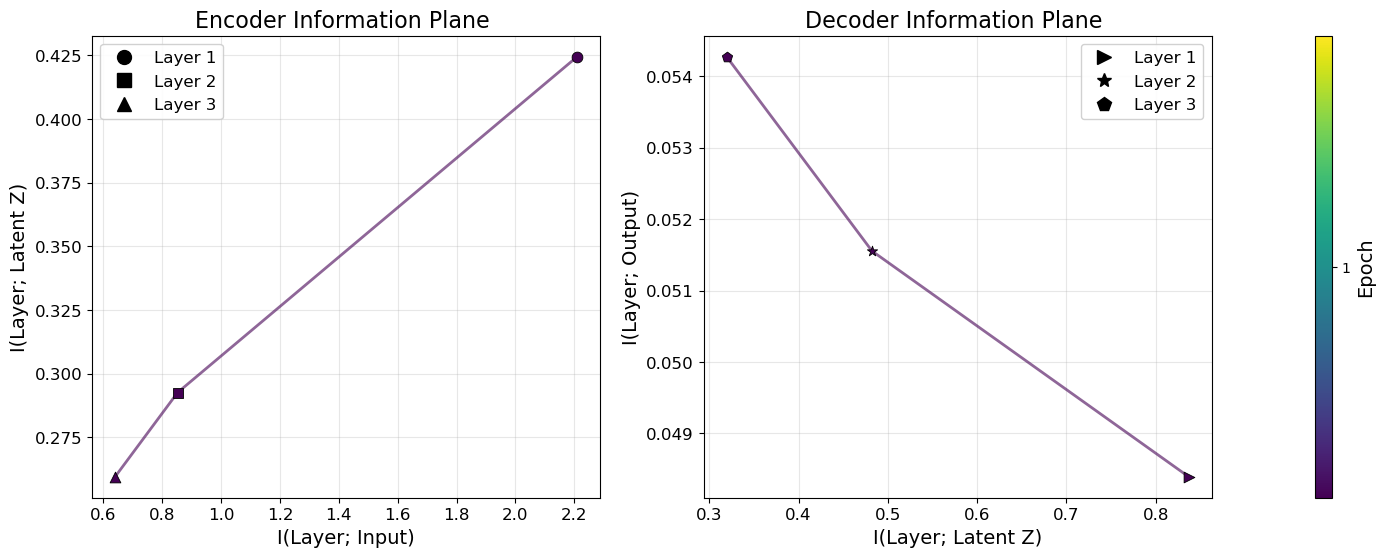

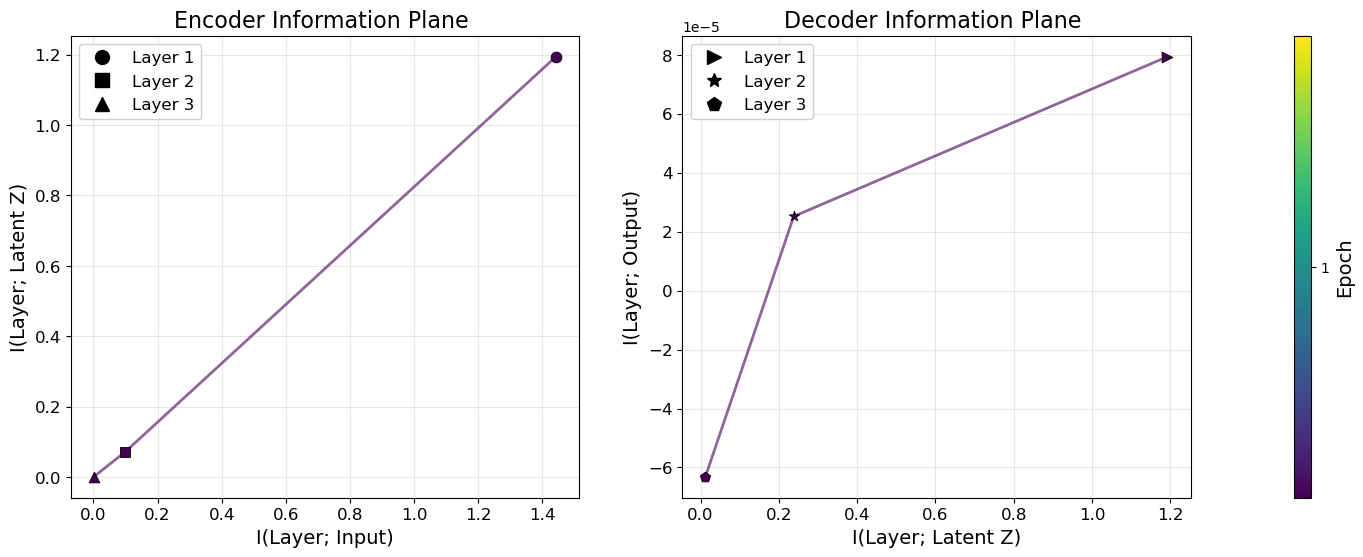

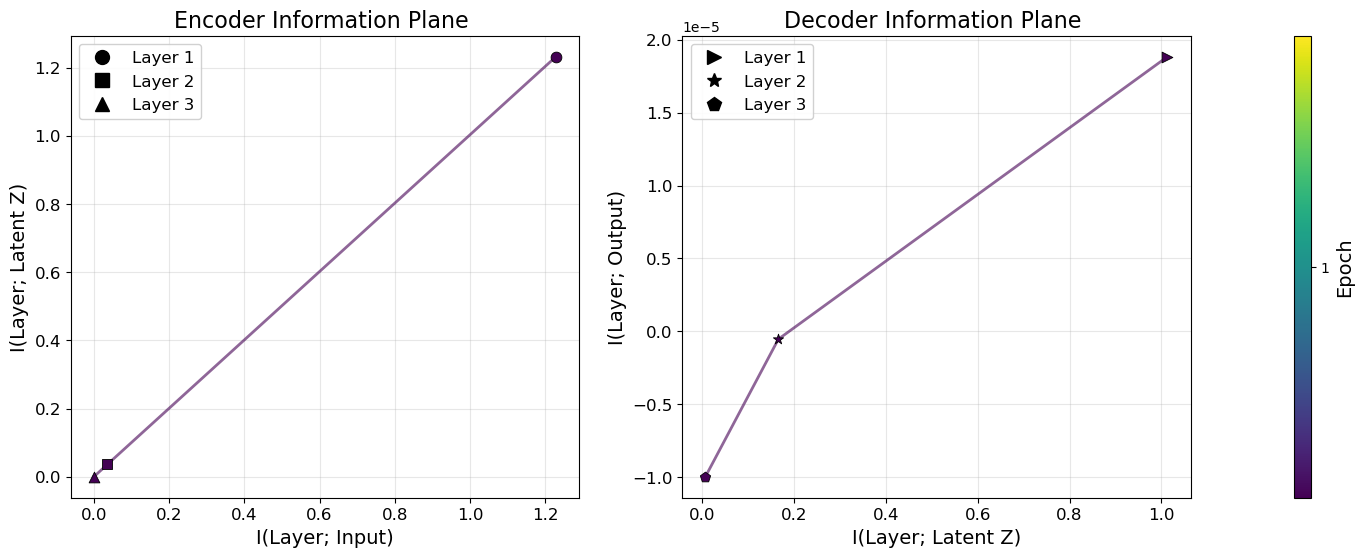

In [79]:
for combination, mi_history in mi_histories.items():
    print(combination)
    PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=2, Step=1)